In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import numpy as np
import seaborn as sns
from collections import defaultdict,Counter
from sklearn.model_selection import train_test_split

In [ ]:

patterns = {
    # Tên đầy đủ dạng đơn giản (ít nhất 2 phần, viết liền hoặc cách)
    "name": re.compile(r"\b[a-z]{3,}[a-z]{3,}\b"),              # full name (e.g., john smith)
    "abbr_name": re.compile(r"\b[a-z]{1,2}[a-z]{3,}\b"),           # jsmith, lwang, etc.
    
    # Các dạng ngày sinh riêng lẻ
    "year_of_birth": re.compile(r"\b(19[5-9]\d|20[0-2]\d)\b"),     # 1950–2029
    "date_of_birth": re.compile(r"\b(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01])\b"),  # MMDD
    "abbr_birthday": re.compile(r"\b\d{6}\b"),                     # dạng 6 số như 820607

    # Các tổ hợp tên + năm hoặc ngày sinh
    "name+year": re.compile(r"\b[a-z]{3,}(19[5-9]\d|20[0-2]\d)\b"),    # john1980, alice1991
    "name+date": re.compile(r"\b[a-z]{3,}(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01])\b"), # john0101

    # Username, email, phone
    "others": re.compile(r"^[a-z0-9_.-]{3,}$"),
    "email_prefix": re.compile(r"\b[a-z0-9_.-]{3,}(?=@)"),
    "phone": re.compile(r"\b1[0-9]{9,}\b")
}


def analyze_dataset(filepath):
    stats = defaultdict(int)
    total = 0

    with open(filepath, encoding='utf-8', errors='ignore') as f:
        for line in f:
            pw = line.strip().lower()
            if not pw:
                continue
            total += 1

            # Check từng biểu thức PII
            if patterns["name"].search(pw):
                stats["name"] += 1
            if patterns["abbr_name"].search(pw):
                stats["abbr_name"] += 1
            if patterns["year_of_birth"].search(pw):
                stats["year_of_birth"] += 1
            if patterns["date_of_birth"].search(pw):
                stats["date_of_birth"] += 1
            if patterns["abbr_birthday"].search(pw):
                stats["abbr_birthday"] += 1
            if patterns["name+year"].search(pw):
                stats["name+year"] += 1
            if patterns["name+date"].search(pw):
                stats["name+date"] += 1
            if patterns["others"].search(pw):
                stats["others"] += 1
            if patterns["email_prefix"].search(pw):
                stats["email_prefix"] += 1
            if patterns["phone"].search(pw):
                stats["phone"] += 1

    # Tính tỉ lệ phần trăm
    results = {k: round(v / total * 100, 2) for k, v in stats.items()}
    return results,total


In [14]:
datasets = {
    "RockYou": "Dataset//rockyou.txt",
    "LinkedIn": "Dataset\linkedin.txt",
    "phpBB": "Dataset\phpbb.txt",
    "MySpace": "Dataset\myspace.txt",
    "Yahoo": "Dataset\yahoo.txt"
}

# Khởi tạo danh sách kết quả
rows = []

for name, path in datasets.items():
    print(f"🔍 Đang phân tích {name}...")
    stats, total = analyze_dataset(path)

    # Tạo 1 dict cho 1 dòng trong bảng
    row = {"Dataset": name, "Total": total}
    for k, v in stats.items():
        row[k] = round(v, 2)
    rows.append(row)

# Tạo DataFrame
df = pd.DataFrame(rows)

# Đưa cột 'Dataset' về làm chỉ mục
df.set_index("Dataset", inplace=True)

# Sắp xếp cột nếu cần
df = df[sorted([col for col in df.columns if col != "Total"]) + ["Total"]]

# Hiển thị
print("\n📊 Bảng phân tích PII trong mật khẩu:\n")
df


🔍 Đang phân tích RockYou...
🔍 Đang phân tích LinkedIn...
🔍 Đang phân tích phpBB...
🔍 Đang phân tích MySpace...
🔍 Đang phân tích Yahoo...

📊 Bảng phân tích PII trong mật khẩu:



,abbr_birthday,abbr_name,date_of_birth,email_prefix,name,name+date,name+year,phone,username,year_of_birth,Total
Dataset,,,,,,,,,,,
RockYou,2.80,32.32,0.03,0.51,29.77,1.29,2.09,0.43,95.68,0.12,14344373
LinkedIn,1.37,26.26,0.05,1.03,24.74,1.84,3.41,0.23,94.76,0.21,47915722
phpBB,4.22,45.42,0.09,0.18,40.49,0.50,1.30,0.13,98.52,0.05,184388
MySpace,0.27,14.16,0.02,0.18,11.15,0.92,1.51,0.01,93.10,0.02,36228
Yahoo,0.03,98.13,0.00,0.00,88.74,0.00,0.01,0.00,91.79,0.00,3745855


In [ ]:
import re
from collections import defaultdict

# Regex cho từng dạng
patterns = {
    "name+year": re.compile(r"^[a-z]{3,}(19[5-9]\d|20[0-2]\d)$"),
    "name+date": re.compile(r"^[a-z]{3,}(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01])$"),
    "name+phone": re.compile(r"^[a-z]{3,}[_]?\d{4}$"),
    "email+phone": re.compile(r"^[a-z0-9_.-]{3,}[_]?\d{4}$"),
    "name+123": re.compile(r"^[a-z]{3,}123$")
}

# Kết quả
results = defaultdict(list)

with open("target_password_30.txt", "r", encoding="utf-8") as f:
    for line in f:
        pw = line.strip()
        for key, pattern in patterns.items():
            if len(results[key]) < 5 and pattern.match(pw):
                results[key].append(pw)

# In kết quả
print("🔍 5 ví dụ cho mỗi mẫu PII-based password:\n")
for key, pw_list in results.items():
    print(f"{key}:")
    for pw in pw_list:
        print(f"  - {pw}")
    print()


🔍 5 ví dụ cho mỗi mẫu PII-based password:

name+year:
  - bagong1972
  - superbubble1975
  - chaquetita1991
  - madrep1989
  - josekike2003

name+date:
  - ssvadq0524
  - compbug0103
  - peter0115
  - cacosca0922
  - peckenpaugh0204

name+phone:
  - rhontin_0057
  - deadlylove4619
  - nicolegk_2000
  - tangruknu5031
  - berna_6730

email+phone:
  - rhontin_0057
  - deadlylove4619
  - nicolegk_2000
  - tangruknu5031
  - berna_6730

name+123:
  - nicotin123
  - marysia123
  - baron123
  - jessica123
  - dolnad123



In [2]:
# Đường dẫn đến file rockyou.txt
file_path = 'rockyou.txt'

# 1. Kiểm tra kích thước file
file_size = os.path.getsize(file_path)
print(f'Kích thước file: {file_size / (1024 * 1024):.2f} MB')

Kích thước file: 635.11 MB


In [3]:
# 2. Đọc dữ liệu từng dòng vào pandas
with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
    lines = [line.strip() for line in f if line.strip()]

# Chuyển thành DataFrame
df = pd.DataFrame([line.strip() for line in lines], columns=['password'])


In [4]:
# 3. Chia tập 80% huấn luyện, 20% kiểm tra
with open('target_password_30.txt', 'r', encoding='latin-1', errors='ignore') as f:
    test_data = [line.strip() for line in f if line.strip()]

test_df = pd.DataFrame(test_data, columns=['password'])

# 5. In kết quả
print(f'\nTổng số mật khẩu: {len(lines)}')
print(f'Số lượng tập kiểm tra theo target: {len(test_data)}')


Tổng số mật khẩu: 63378468
Số lượng tập kiểm tra theo target: 70760006


In [5]:
def evaluate_accuracy_by_length(test_data, gen_files, min_len=7, max_len=15):
    # Đọc test set và phân loại theo độ dài
    results = defaultdict(dict)
    test_by_length = {l: set() for l in range(min_len, max_len + 1)}
    for line in test_data:
        pw = line.strip()
        if min_len <= len(pw) <= max_len:
            test_by_length[len(pw)].add(pw)

    # Đọc từng file sinh mật khẩu
    for name, gen_path in gen_files.items():
        print(f"\n=== 📊 Đánh giá mô hình: {name} ===")
        gen_data = set()
        with open(gen_path, 'r', encoding='latin-1', errors='ignore') as f:
            for line in f:
                gen_data.add(line.strip())

        # Kiểm tra theo từng độ dài
        for length in range(min_len, max_len + 1):
            test_set = test_by_length[length]
            if not test_set:
                continue
            matched = sum(1 for pw in test_set if pw in gen_data)
            acc = (matched / len(test_set)) * 100
            results[name][length] = acc
            print(f"🔹 Length = {length}: {matched}/{len(test_set)} matched → Accuracy = {acc:.4f}%")
    return results


In [6]:
def plot_accuracy_by_length(results, min_len=7,max_len=15):
    labels = list(range(min_len, max_len + 1))
    fig, ax = plt.subplots(figsize=(10, 6))

    x = range(len(labels))
    bar_width = 0.35
    offset = -bar_width / 2

    # Thiết lập kiểu vẽ cố định cho từng mô hình
    model_styles = {
        "VQ-PassGPT": {"color": "lightgreen", "hatch": "//"},
        "PagPassGPT": {"color": "lightcoral", "hatch": ""},
    }

    for i, (model_name, acc_dict) in enumerate(results.items()):
        values = [acc_dict.get(l, 0) for l in labels]
        x_shifted = [pos + offset + i * bar_width for pos in x]
        
        style = model_styles.get(model_name, {"color": None, "hatch": None})
        ax.bar(
            x_shifted, values,
            width=bar_width,
            label=model_name,
            color=style["color"],
            hatch=style["hatch"],
            edgecolor='black'
        )

    ax.set_xlabel('Password Length', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    #ax.set_title('Password Guessing Accuracy by Length', fontsize=14)
    ax.set_xticks(list(x))
    ax.set_xticklabels(labels)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()



=== 📊 Đánh giá mô hình: PagPassGPT ===
🔹 Length = 7: 41247/520634 matched → Accuracy = 7.9225%
🔹 Length = 8: 82542/1097767 matched → Accuracy = 7.5191%
🔹 Length = 9: 55213/2454366 matched → Accuracy = 2.2496%
🔹 Length = 10: 38698/7608876 matched → Accuracy = 0.5086%
🔹 Length = 11: 11184/10935028 matched → Accuracy = 0.1023%
🔹 Length = 12: 6172/11300855 matched → Accuracy = 0.0546%
🔹 Length = 13: 0/10513376 matched → Accuracy = 0.0000%
🔹 Length = 14: 0/7935290 matched → Accuracy = 0.0000%
🔹 Length = 15: 0/5507855 matched → Accuracy = 0.0000%

=== 📊 Đánh giá mô hình: VQ-PassGPT ===
🔹 Length = 7: 43978/520634 matched → Accuracy = 8.4470%
🔹 Length = 8: 88556/1097767 matched → Accuracy = 8.0669%
🔹 Length = 9: 68706/2454366 matched → Accuracy = 2.7993%
🔹 Length = 10: 80650/7608876 matched → Accuracy = 1.0599%
🔹 Length = 11: 71703/10935028 matched → Accuracy = 0.6557%
🔹 Length = 12: 68282/11300855 matched → Accuracy = 0.6042%
🔹 Length = 13: 58046/10513376 matched → Accuracy = 0.5521%
🔹 Lengt

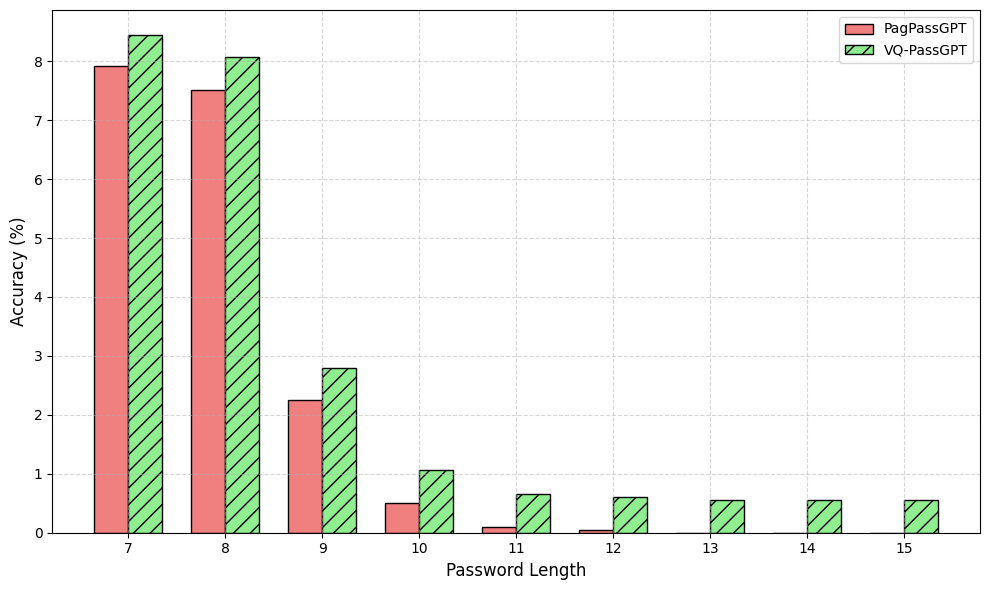

In [7]:
gen_files = {
    "PagPassGPT": "pagpassgpt_GEN/pagpassgpt_gen_1e8.txt",
    "VQ-PassGPT": "vq-passgpt_GEN/vq-passgpt_gen_1e8.txt"
}

results = evaluate_accuracy_by_length(test_data, gen_files)
plot_accuracy_by_length(results)


In [15]:
# Danh sách generator và số lượng
generators = ['pcfg','omen','passgan','passgpt','pagpassgpt','vq-passgpt']
sizes = ['1e5', '1e6', '1e7', '1e8']
# Đảm bảo test_data đã strip trước
test_data = [pw.strip() for pw in test_data]
test_data_set = set(test_data)
# Dictionary lưu accuracy
accuracies = {}

# Tính accuracy
for gen in generators:
    accuracies[gen.upper()] = {}
    for size in sizes:
        print(f'==> Đang tiến hành với model {gen} với {size} mật khẩu.')
        file_path = f'{gen}_GEN/{gen}_gen_{size}.txt'
        match_count = 0
        with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
            for line in f:
                if line.strip() in test_data_set:
                    match_count += 1
        accuracy = (match_count / len(test_data_set)) * 100 if test_data else 0
        accuracies[gen.upper()][size] = accuracy

# Tạo DataFrame từ dict
accuracy_df = pd.DataFrame(accuracies).T
accuracy_df = accuracy_df[sizes]

# Hiển thị bảng kết quả
print("\n🔎 Bảng độ chính xác (Accuracy %) trên tập kiểm thử:\n")
accuracy_df.round(4)


==> Đang tiến hành với model pcfg với 1e5 mật khẩu.
==> Đang tiến hành với model pcfg với 1e6 mật khẩu.
==> Đang tiến hành với model pcfg với 1e7 mật khẩu.
==> Đang tiến hành với model pcfg với 1e8 mật khẩu.
==> Đang tiến hành với model omen với 1e5 mật khẩu.
==> Đang tiến hành với model omen với 1e6 mật khẩu.
==> Đang tiến hành với model omen với 1e7 mật khẩu.
==> Đang tiến hành với model omen với 1e8 mật khẩu.
==> Đang tiến hành với model passgan với 1e5 mật khẩu.
==> Đang tiến hành với model passgan với 1e6 mật khẩu.
==> Đang tiến hành với model passgan với 1e7 mật khẩu.
==> Đang tiến hành với model passgan với 1e8 mật khẩu.
==> Đang tiến hành với model passgpt với 1e5 mật khẩu.
==> Đang tiến hành với model passgpt với 1e6 mật khẩu.
==> Đang tiến hành với model passgpt với 1e7 mật khẩu.
==> Đang tiến hành với model passgpt với 1e8 mật khẩu.
==> Đang tiến hành với model pagpassgpt với 1e5 mật khẩu.
==> Đang tiến hành với model pagpassgpt với 1e6 mật khẩu.
==> Đang tiến hành với model

,1e5,1e6,1e7,1e8
PCFG,0.0001,0.0004,0.0004,0.0004
OMEN,0.0005,0.0105,0.0786,0.3826
PASSGAN,0.0001,0.0005,0.0043,0.0266
PASSGPT,0.0005,0.0046,0.0445,0.3427
PAGPASSGPT,0.0005,0.0047,0.0447,0.3745
VQ-PASSGPT,0.0008,0.0059,0.0648,0.9269


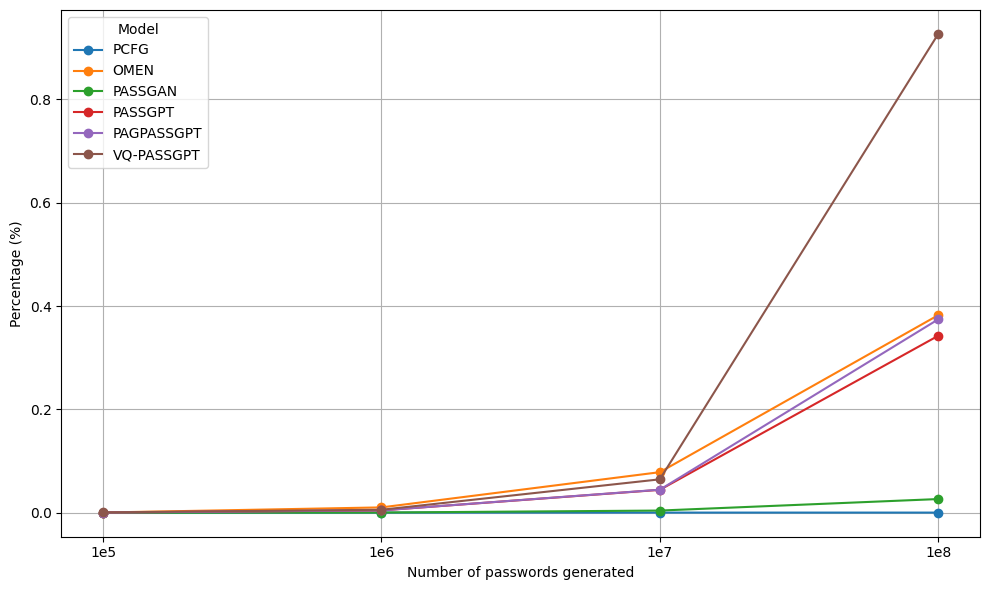

In [16]:
# Đặt kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ từng dòng (mỗi mô hình)
for model in accuracy_df.index:
    plt.plot(sizes, accuracy_df.loc[model], marker='o', label=model)

# Add title and labels
#plt.title('Password prediction rate (%) with different sizes')
plt.xlabel('Number of passwords generated')
plt.ylabel('Percentage (%)')
plt.grid(True)
plt.legend(title='Model')
plt.tight_layout()

# Display the plot
plt.show()

Đang xử lý pagpassgpt_GEN/pagpassgpt_gen_1e5.txt
Đang xử lý pagpassgpt_GEN/pagpassgpt_gen_1e6.txt
Đang xử lý pagpassgpt_GEN/pagpassgpt_gen_1e7.txt
Đang xử lý pagpassgpt_GEN/pagpassgpt_gen_1e8.txt
Đang xử lý vq-passgpt_GEN/vq-passgpt_gen_1e5.txt
Đang xử lý vq-passgpt_GEN/vq-passgpt_gen_1e6.txt
Đang xử lý vq-passgpt_GEN/vq-passgpt_gen_1e7.txt
Đang xử lý vq-passgpt_GEN/vq-passgpt_gen_1e8.txt


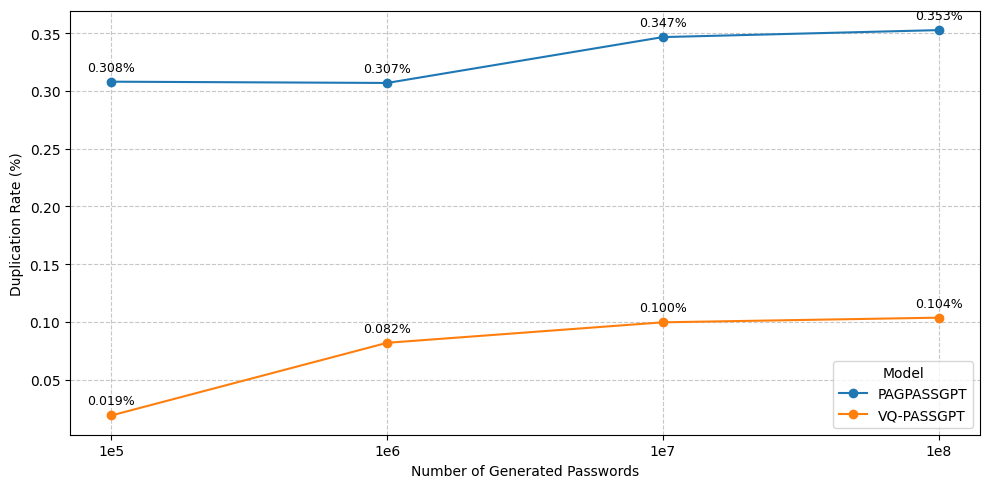

In [3]:
generators = ['pagpassgpt','vq-passgpt']
sizes = ['1e5', '1e6', '1e7','1e8']

# Map size string -> số lượng dòng mong muốn mặc định
size_to_count = {
    '1e5': 10**5,
    '1e6': 10**6,
    '1e7': 10**7,
    '1e8': 10**8
}

duplication_rates = {}

for gen in generators:
    duplication_rates[gen.upper()] = {}
    for size in sizes:
        # Xác định số dòng kỳ vọng (custom nếu có)
        expected_total = size_to_count[size]
        file_path = f'{gen}_GEN/{gen}_gen_{size}.txt'
        print(f'Đang xử lý {file_path}')
        
        with open(file_path, 'r', encoding='latin-1', errors='ignore') as f:
            unique_passwords = set(line.strip() for line in f)

        duplicated = expected_total - len(unique_passwords)
        duplication_rate = (duplicated / expected_total) * 100 if expected_total else 0
        duplication_rates[gen.upper()][size] = duplication_rate

# Create DataFrame for plotting
dup_df = pd.DataFrame(duplication_rates).T
dup_df = dup_df[sizes]  # ensure consistent column order

# Plotting
plt.figure(figsize=(10, 5))

for model in dup_df.index:
    y_values = dup_df.loc[model]
    plt.plot(sizes, y_values, marker='o', label=model)
    
    # Annotate each point with the percentage
    for x, y in zip(sizes, y_values):
        plt.text(x, y - 0.003, f'{y:.3f}%', ha='center', va='bottom', fontsize=9)

#plt.title("Tỷ lệ trùng lặp mật khẩu được sinh bởi các mô hình")
plt.xlabel("Number of Generated Passwords")
plt.ylabel("Duplication Rate (%)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [1]:
import math
from collections import Counter

def load_passwords(filepath, max_lines=1000000):
    with open(filepath, 'r', encoding='utf-8') as f:
        passwords = [line.strip() for _, line in zip(range(max_lines), f) if line.strip()]
    return passwords

# Hàm tính entropy Shannon (gần đúng)
def calculate_shannon_entropy(pw):
    if not pw:
        return 0
    freq = Counter(pw)
    total = len(pw)
    probs = [f / total for f in freq.values()]
    entropy = -sum(p * math.log2(p) for p in probs)
    return entropy * total  # entropy tổng (bit)

def evaluate_passwords(passwords):
    total_length = 0
    entropy_list = []
    len_ge_7 = 0
    entropy_ge_50 = 0

    for pw in passwords:
        total_length += len(pw)
        entropy = calculate_shannon_entropy(pw)
        entropy_list.append(entropy)
        if len(pw) >= 7:
            len_ge_7 += 1
        if entropy >= 30:
            entropy_ge_50 += 1

    avg_len = total_length / len(passwords)
    avg_entropy = sum(entropy_list) / len(passwords)
    pct_len_ge_7 = len_ge_7 / len(passwords) * 100
    pct_entropy_ge_50 = entropy_ge_50 / len(passwords) * 100

    return {
        'avg_len': avg_len,
        'avg_entropy': avg_entropy,
        'pct_len_ge_7': pct_len_ge_7,
        'pct_entropy_ge_50': pct_entropy_ge_50
    }

def print_result(name, result):
    print(f"\n===== {name} =====")
    print(f"Average Length: {result['avg_len']:.2f}")
    print(f"Average Entropy (Shannon): {result['avg_entropy']:.2f} bits")
    print(f"Percentage of passwords with length ≥ 8: {result['pct_len_ge_7']:.2f}%")
    print(f"Percentage of passwords with entropy ≥ 50 bits: {result['pct_entropy_ge_50']:.2f}%")

# Load và đánh giá
pagpass_pw = load_passwords('passgan_GEN\passgan_gen_1e8.txt', max_lines=1000000)
vqpass_pw = load_passwords('passgptv2_GEN//passgptv2_gen_1e8_normal.txt', max_lines=1000000)

pagpass_result = evaluate_passwords(pagpass_pw)
vqpass_result = evaluate_passwords(vqpass_pw)

# In kết quả
print_result("PagPassGPT", pagpass_result)
print_result("VQ-PassGPT", vqpass_result)



===== PagPassGPT =====
Average Length: 7.63
Average Entropy (Shannon): 19.68 bits
Percentage of passwords with length ≥ 8: 75.04%
Percentage of passwords with entropy ≥ 50 bits: 7.04%

===== VQ-PassGPT =====
Average Length: 8.64
Average Entropy (Shannon): 23.90 bits
Percentage of passwords with length ≥ 8: 90.21%
Percentage of passwords with entropy ≥ 50 bits: 18.74%


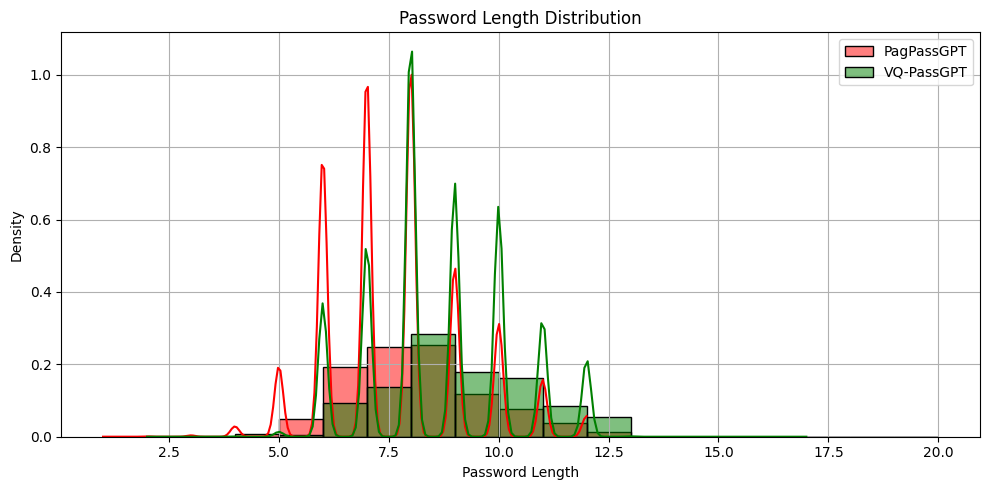

In [4]:
import seaborn as sns

def plot_length_distribution(pagpass_pw, vqpass_pw):
    pag_lengths = [len(pw) for pw in pagpass_pw]
    vq_lengths = [len(pw) for pw in vqpass_pw]

    plt.figure(figsize=(10, 5))
    sns.histplot(pag_lengths, bins=range(4, 21), label='PagPassGPT', color='red', stat='density', kde=True)
    sns.histplot(vq_lengths, bins=range(4, 21), label='VQ-PassGPT', color='green', stat='density', kde=True)
    plt.title("Password Length Distribution")
    plt.xlabel("Password Length")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_length_distribution(pagpass_pw, vqpass_pw)

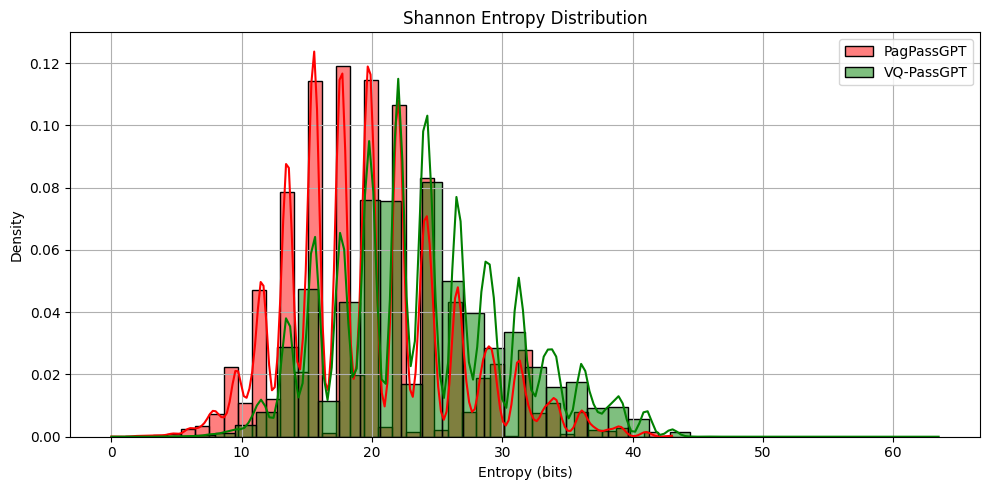

In [5]:
def plot_entropy_distribution(pagpass_pw, vqpass_pw):
    pag_entropy = [calculate_shannon_entropy(pw) for pw in pagpass_pw]
    vq_entropy = [calculate_shannon_entropy(pw) for pw in vqpass_pw]

    plt.figure(figsize=(10, 5))
    sns.histplot(pag_entropy, bins=40, label='PagPassGPT', color='red', stat='density', kde=True)
    sns.histplot(vq_entropy, bins=40, label='VQ-PassGPT', color='green', stat='density', kde=True)
    plt.title("Shannon Entropy Distribution")
    plt.xlabel("Entropy (bits)")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_entropy_distribution(pagpass_pw, vqpass_pw)

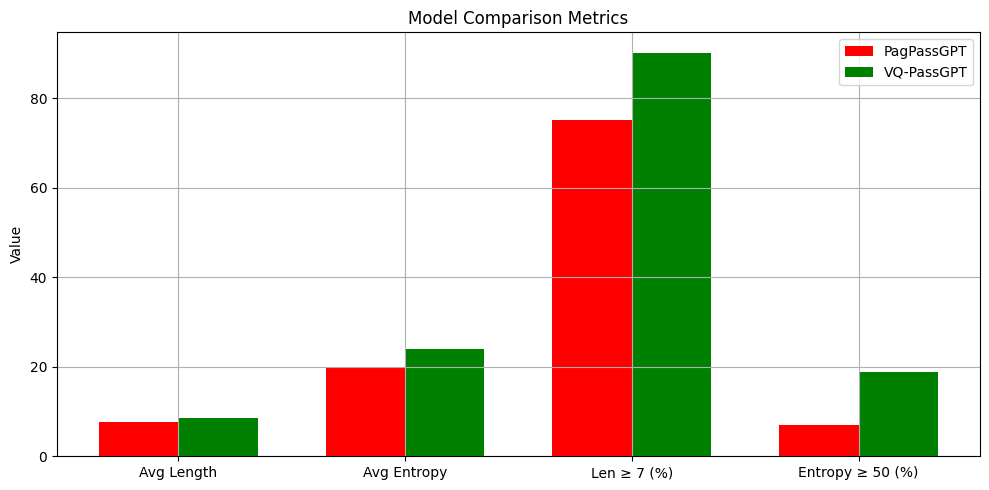

In [6]:
import numpy as np

def plot_summary_bar(pag_result, vq_result):
    labels = ['Avg Length', 'Avg Entropy', 'Len ≥ 7 (%)', 'Entropy ≥ 50 (%)']
    pag_values = [
        pag_result['avg_len'], 
        pag_result['avg_entropy'],
        pag_result['pct_len_ge_7'],
        pag_result['pct_entropy_ge_50']
    ]
    vq_values = [
        vq_result['avg_len'], 
        vq_result['avg_entropy'],
        vq_result['pct_len_ge_7'],
        vq_result['pct_entropy_ge_50']
    ]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, pag_values, width, label='PagPassGPT', color='red')
    plt.bar(x + width/2, vq_values, width, label='VQ-PassGPT', color='green')

    plt.ylabel('Value')
    plt.title('Model Comparison Metrics')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_summary_bar(pagpass_result, vqpass_result)